In [1]:
using_numpy = False
try:
    import cupy as np
except:
    import numpy as np
    using_numpy = True
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


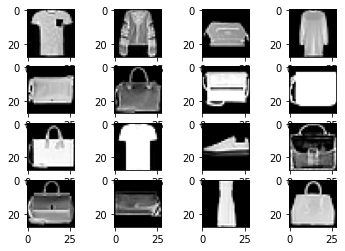

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        if not using_numpy:
            img = img.get()
        axarr[i, j].imshow(img)

## 3.3 Implementing the algorithm

In [25]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))
#     return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def loss(yhat, y):
    if yhat in (0, 1):
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

In [26]:
def forward(params, x):
    """Compute Forward Pass"""
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["w2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    
    return forward_res

def backprop(x, y, params):
    """Compute Gradients"""
    x = x.reshape(28**2, 1)
    
    fwd_pass = forward(params, x)
    
    # Backwards Pass
    dL_dz2 = (fwd_pass["a2"] - y)
    dL_dz1 = dL_dz2 * params["w2"].T * sigmoid_d(fwd_pass["z1"])
    
    grad = {}
    grad["w2"] = dL_dz2 * fwd_pass["a1"].T
    grad["b2"] = dL_dz2
    
    grad["W1"] = dL_dz1 @ x.T
    grad["b1"] = dL_dz1

    return grad

In [27]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(params, x)
    return forward_res["a2"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

In [28]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData       

In [29]:
def mlp(xs, ys, devxs, devys, n_epochs=3, learning_rate=0.1, momentum=0, batch_size=-1, h=19):
    """Initialize and train model on a dataset, outputting validation set accuracy/loss"""
    # Initialize Hyperparameters
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]
    
    lr = learning_rate
    a = momentum # alpha
    
    
    if batch_size == -1:
        batch_size = nData
    print("nData:", nData, "Hidden Layer size:", h, "Learning Rate:", eta, "Momentum:", momentum, "Batch Size:", batch_size)
    
    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []
    
    # Initialize model parameters
    params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    v = {
        "W1": np.zeros_like(params["W1"]),
        "b1": np.zeros_like(params["b1"]),
        "w2": np.zeros_like(params["w2"]),
        "b2": np.zeros_like(params["b2"]),
    }
    
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        
        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            grad["w2"] = np.zeros_like(params["w2"])
            grad["b2"] = np.zeros_like(params["b2"])
            grad["W1"] = np.zeros_like(params["W1"])
            grad["b1"] = np.zeros_like(params["b1"])
            
            for i in batch:
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                
                grad["w2"] += grad_i["w2"] / batch_size
                grad["b2"] += grad_i["b2"] / batch_size
                grad["W1"] += grad_i["W1"] / batch_size
                grad["b1"] += grad_i["b1"] / batch_size
                
            v["W1"] = a * v["W1"] + (1-a) * grad["W1"]
            v["b1"] = a * v["b1"] + (1-a) * grad["b1"]
            v["w2"] = a * v["w2"] + (1-a) * grad["w2"]
            v["b2"] = a * v["b2"] + (1-a) * grad["b2"]
            
            params["W1"] -= lr * v["W1"]
            params["b1"] -= lr * v["b1"]
            params["w2"] -= lr * v["w2"]
            params["b2"] -= lr * v["b2"]            

#         t_loss, t_acc = nvalidate(xs, ys, params)
#         t_losses.append(t_loss)
#         t_accs.append(t_acc)
#         print("Train Acc:", t_acc, "Train Loss:", t_loss)
        
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [24]:
epochs, t_losses, t_accs, v_losses, v_accs, _ = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0.2,
    batch_size=4,
    h=29,
)

nData: 12000 Hidden Layer size: 29 Learning Rate: 0.01 Momentum: 0.2 Batch Size: 4
----------------------------------
Epoch: 0
Val Acc: 0.955 Val Loss: 0.15343372922109724
----------------------------------
Epoch: 1
Val Acc: 0.964 Val Loss: 0.11388876131548978
----------------------------------
Epoch: 2
Val Acc: 0.964 Val Loss: 0.1046459847462477
----------------------------------
Epoch: 3
Val Acc: 0.973 Val Loss: 0.09348737786082326
----------------------------------
Epoch: 4
Val Acc: 0.973 Val Loss: 0.0880723049934345
----------------------------------
Epoch: 5
Val Acc: 0.974 Val Loss: 0.08409487566465852
----------------------------------
Epoch: 6
Val Acc: 0.977 Val Loss: 0.08041799109866486
----------------------------------
Epoch: 7
Val Acc: 0.973 Val Loss: 0.07915320058744335
----------------------------------
Epoch: 8
Val Acc: 0.982 Val Loss: 0.07472505881031573
----------------------------------
Epoch: 9
Val Acc: 0.977 Val Loss: 0.0744224090350042


In [19]:
epochs, t_losses, t_accs, v_losses, v_accs, _ = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0.2,
    batch_size=4,
    h=29,
)

nData: 12000 Hidden Layer size: 29 Learning Rate: 0.01 Momentum: 0.2 Batch Size: 4
Epoch: 0
Val Acc: 0.963 Val Loss: 0.144750786293812
----------------------------------


Epoch: 1
Val Acc: 0.964 Val Loss: 0.11808561455179908
----------------------------------


Epoch: 2
Val Acc: 0.969 Val Loss: 0.09960139909922827
----------------------------------


Epoch: 3
Val Acc: 0.966 Val Loss: 0.09662933564396077
----------------------------------


Epoch: 4
Val Acc: 0.968 Val Loss: 0.09367133047940575
----------------------------------


Epoch: 5
Val Acc: 0.975 Val Loss: 0.08376091593609811
----------------------------------


Epoch: 6
Val Acc: 0.976 Val Loss: 0.07916172172436042
----------------------------------


Epoch: 7
Val Acc: 0.977 Val Loss: 0.07876286369262248
----------------------------------


Epoch: 8
Val Acc: 0.978 Val Loss: 0.07580065407265256
----------------------------------


Epoch: 9
Val Acc: 0.981 Val Loss: 0.07032945826138284
----------------------------------




In [13]:
epochs, t_losses, t_accs, v_losses, v_accs, _ = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0,
    batch_size=8,
    h=29,
)

nData: 12000 Hidden Layer size: 29 Learning Rate: 0.01 Momentum: 0 Batch Size: 8
Epoch: 0
Val Acc: 0.957 Val Loss: 0.22322280644802334
----------------------------------


Epoch: 1
Val Acc: 0.963 Val Loss: 0.14494020428307283
----------------------------------


Epoch: 2
Val Acc: 0.965 Val Loss: 0.12263644829080093
----------------------------------


Epoch: 3
Val Acc: 0.966 Val Loss: 0.11157716072960605
----------------------------------


Epoch: 4
Val Acc: 0.966 Val Loss: 0.10664672556817828
----------------------------------


Epoch: 5
Val Acc: 0.967 Val Loss: 0.10287637588517448
----------------------------------


Epoch: 6
Val Acc: 0.967 Val Loss: 0.09682303706366566
----------------------------------


Epoch: 7
Val Acc: 0.97 Val Loss: 0.09911647519616157
----------------------------------


Epoch: 8
Val Acc: 0.969 Val Loss: 0.09170448874846576
----------------------------------


Epoch: 9
Val Acc: 0.972 Val Loss: 0.08871338719381718
----------------------------------




In [75]:
epochs, t_losses, t_accs, v_losses, v_accs = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0,
    batch_size=8,
    h=29,
)

nData: 12000 Hidden Layer size: 29 Learning Rate: 0.01 Momentum: 0 Batch Size: 8
Epoch: 0
Train Acc: 94.49166666666666 Train Loss: 0.2365881067534589
Val Acc: 95.5 Val Loss: 0.2226498152959708
----------------------------------


Epoch: 1
Train Acc: 95.56666666666666 Train Loss: 0.16273607938347412
Val Acc: 95.89999999999999 Val Loss: 0.14769763783586404
----------------------------------


Epoch: 2
Train Acc: 95.95833333333333 Train Loss: 0.14016205256135558
Val Acc: 96.39999999999999 Val Loss: 0.12370701860808335
----------------------------------


Epoch: 3
Train Acc: 96.075 Train Loss: 0.13096573138979434
Val Acc: 96.39999999999999 Val Loss: 0.11428308739006358
----------------------------------


Epoch: 4
Train Acc: 96.075 Train Loss: 0.1272108045390522
Val Acc: 96.3 Val Loss: 0.11018682624019432
----------------------------------


Epoch: 5
Train Acc: 96.23333333333333 Train Loss: 0.1210699919358938
Val Acc: 96.89999999999999 Val Loss: 0.103829619882749
--------------------------

In [61]:
epochs, t_losses, t_accs, v_losses, v_accs = mlp(
    trainxs, trainys, 
    devxs, devys,
    n_epochs=10,
    learning_rate=0.01,
    momentum=0,
    batch_size=1,
    h=19,
)

nData: 12000 Hidden Layer size: 19 Learning Rate: 0.01 Momentum: 0 Batch Size: 1
Epoch: 0
Train Acc: 96.40833333333333 Train Loss: 0.11293444187124507
Val Acc: 96.89999999999999 Val Loss: 0.09634752771070201
----------------------------------


Epoch: 1
Train Acc: 96.35000000000001 Train Loss: 0.10982611765980327
Val Acc: 97.2 Val Loss: 0.09213429310336331
----------------------------------


Epoch: 2
Train Acc: 97.26666666666667 Train Loss: 0.0843917886240612
Val Acc: 98.1 Val Loss: 0.07138362359474437
----------------------------------


Epoch: 3
Train Acc: 97.1 Train Loss: 0.08772298193273179
Val Acc: 97.39999999999999 Val Loss: 0.07550390859209746
----------------------------------


Epoch: 4
Train Acc: 97.56666666666666 Train Loss: 0.07449246349687402
Val Acc: 98.2 Val Loss: 0.0649593015222898
----------------------------------


Epoch: 5
Train Acc: 98.075 Train Loss: 0.06453957161071688
Val Acc: 98.4 Val Loss: 0.05896879695110446
----------------------------------


Epoch: 6
Trai

In [ ]:
update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)

In [42]:
momentum = 0
epochs, t_losses, t_accs, v_losses, v_accs = mlp(
    trainxs, trainys, 
    devxs, devys, 
    learning_rate=0.4,
    momentum=0,
    batch_size=-1,
    h=19,
)

nData: 12000 Hidden Layer size: 19 Learning Rate: 0.4 Momentum: 0 Batch Size: 12000
Epoch: 0
Train Acc: 46.800000000000004 Train Loss: 0.703357876648778
Val Acc: 45.6 Val Loss: 0.7053220881144602
----------------------------------


Epoch: 1
Train Acc: 63.916666666666664 Train Loss: 0.6809195878165692
Val Acc: 62.0 Val Loss: 0.6822092229837635
----------------------------------


Epoch: 2
Train Acc: 70.89999999999999 Train Loss: 0.6587480886879339
Val Acc: 69.89999999999999 Val Loss: 0.6595969116505993
----------------------------------


